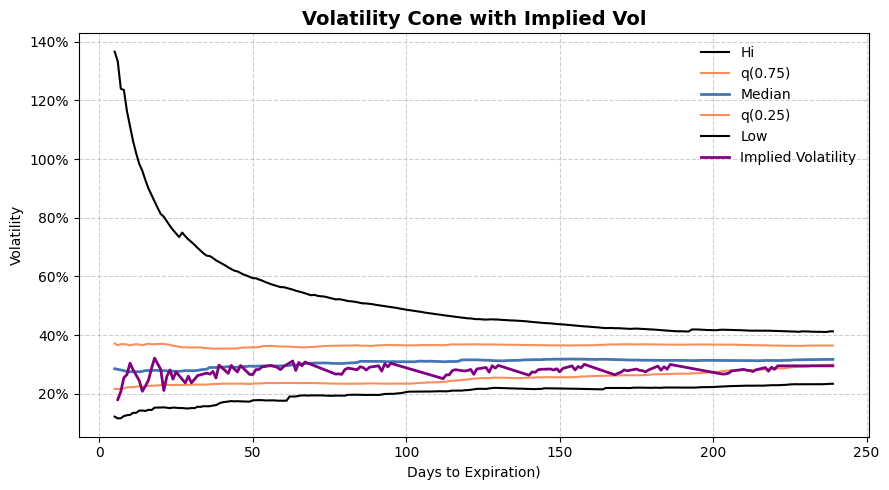

<Axes: title={'center': 'Volatility Cone with Implied Vol'}, xlabel='Days to Expiration)', ylabel='Volatility'>

In [6]:
import sys, pandas as pd, numpy as np, yfinance as yf, importlib
sys.path.append("../src")

import vol_cone

df1 = pd.read_csv("../data/aapl_eod_202303.csv")
ticker = yf.Ticker("AAPL")
df2 = ticker.history(period="60mo")

#windows = [20, 40, 60, 120, 240]
windows = tuple(range(5, 240))
summary = vol_cone.five_n_sum(df2, windows=windows, T = 1210)

iv_curve = vol_cone.iv_curve_from_snapshot(df1)

# Plot with IV overlay
vol_cone.plot_realized_vol_cone(
    summary,
    title="Volatility Cone with Implied Vol",
    iv_curve=iv_curve
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Axes: title={'center': 'Historical  Log Returns'}, xlabel='date'>

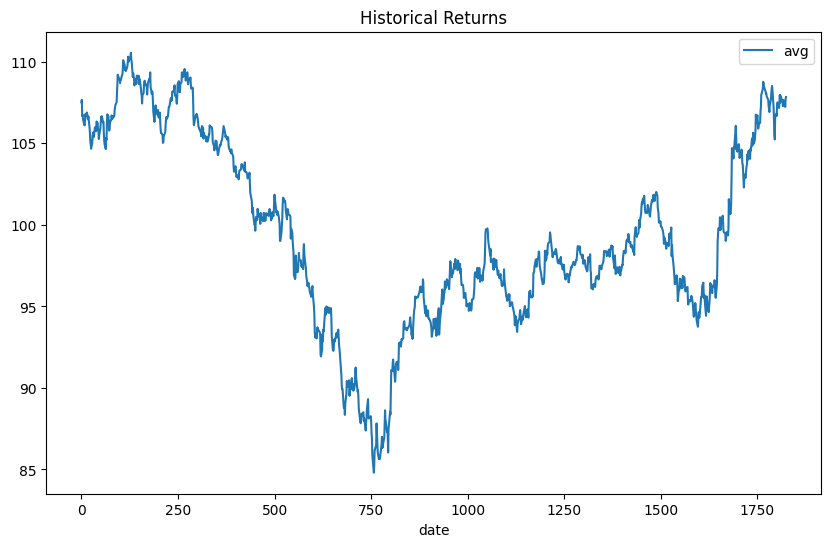

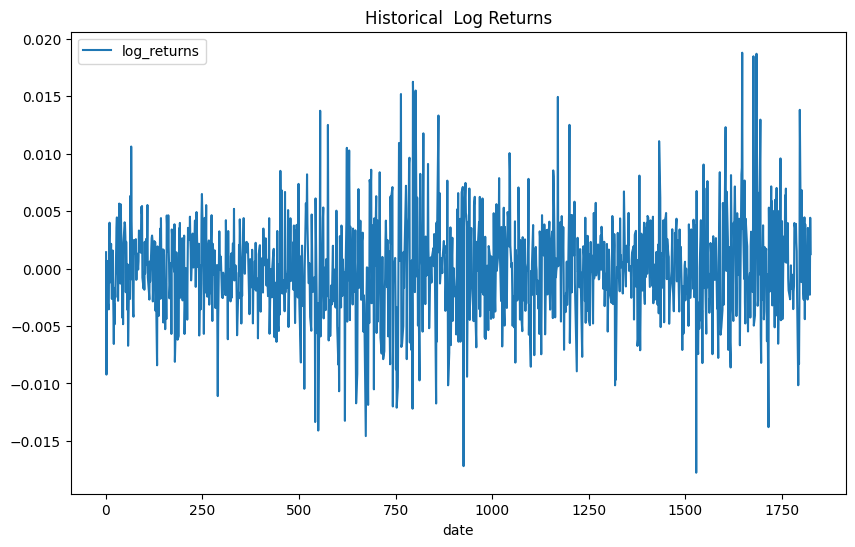

In [7]:
%load_ext autoreload
%autoreload 2
import sys, pandas as pd, numpy as np, yfinance as yf, importlib
from arch import arch_model
sys.path.append("../src")

import vol_estimator
df1 = pd.read_csv("../data/aapl_eod_202303.csv")
ticker = yf.Ticker("FXE")
df2 = ticker.history(period="60mo")

df2 = vol_estimator.zero_time((vol_estimator.prep_index(df2)))

#windows = [20, 40, 60, 120, 240]
windows = tuple(range(5, 120))

df2.plot(x="date",y="avg", title="Historical Returns", figsize=(10, 6))
l_r = vol_estimator.log_returns(df2)
l_r.plot(x="date",y="log_returns", title="Historical  Log Returns", figsize=(10, 6))

(3.144619416398912e-06, 0.13146191023068393, 0.7)
     message: Inequality constraints incompatible
     success: False
      status: 4
         fun: 2163.194374723803
           x: [ 3.145e-06  1.315e-01  7.000e-01]
         nit: 1
         jac: [-3.424e+08 -3.240e+04 -2.208e+04]
        nfev: 4
        njev: 1
 multipliers: [ 0.000e+00]
 param_names: ('omega', 'alpha', 'beta')


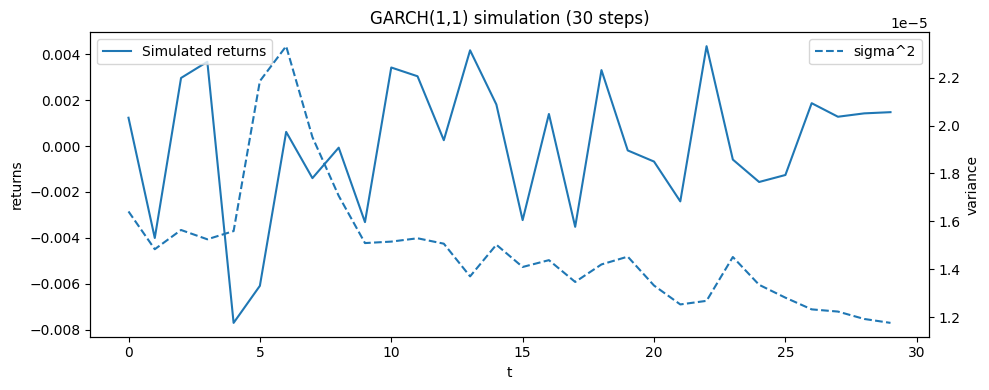

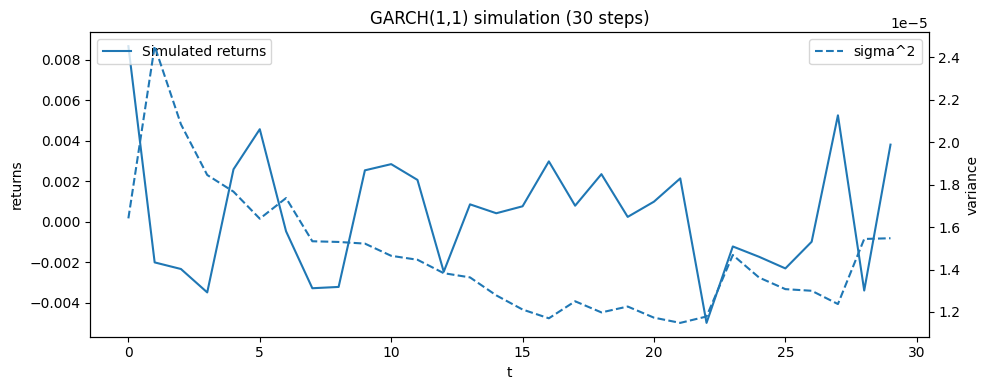

In [ ]:
import matplotlib.pyplot as plt
guess = vol_estimator.s_param(l_r["log_returns"])
mle = vol_estimator.QMLE(guess,l_r["log_returns"],1e-8)


print(guess)
print(mle)
omega, alpha, beta = mle.x
rng = np.random.default_rng(42)
sim,sigma2 = vol_estimator.simul((omega, alpha, beta),omega/(1-alpha-beta),l_r["log_returns"].iloc[-1],30,rng=rng)
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(sim, label="Simulated returns")
ax1.set_xlabel("t")
ax1.set_ylabel("returns")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(sigma2, "--", label="sigma^2")
ax2.set_ylabel("variance")
ax2.legend(loc="upper right")

plt.title("GARCH(1,1) simulation (30 steps)")
plt.tight_layout()
plt.show()

sim1,sigma21 = vol_estimator.simul((omega, alpha, beta),omega/(1-alpha-beta),l_r["log_returns"].iloc[-1],30,rng=rng)
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(sim1, label="Simulated returns")
ax1.set_xlabel("t")
ax1.set_ylabel("returns")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(sigma21, "--", label="sigma^2")
ax2.set_ylabel("variance")
ax2.legend(loc="upper right")

plt.title("GARCH(1,1) simulation (30 steps)")
plt.tight_layout()
plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


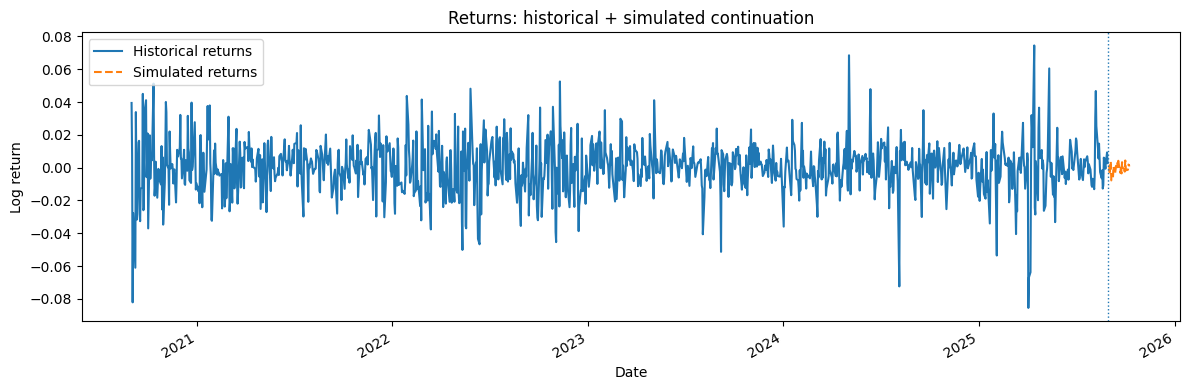

In [ ]:
%load_ext autoreload
%autoreload 2
from pandas.tseries.offsets import BDay

df3 = ticker.history(period="60mo")
l_r = vol_estimator.log_returns(vol_estimator.date_time(vol_estimator.prep_index(df3)))

last_date  = pd.to_datetime(l_r["date"].iloc[-1])
future_idx = pd.bdate_range(last_date + BDay(1), periods=len(sim))

hist_idx   = pd.to_datetime(l_r["date"]).to_numpy()

full_index = pd.DatetimeIndex(np.concatenate([hist_idx, future_idx.to_numpy()]))

hist_vals = l_r["log_returns"].to_numpy()
sim_padded = np.concatenate([np.full(hist_vals.shape, np.nan), sim])
hist_padded = np.concatenate([hist_vals, np.full(sim.shape, np.nan)])

cont_df = pd.DataFrame(
    {
        "returns_hist": hist_padded,
        "returns_sim":  sim_padded,
    },
    index=full_index
)

fig, ax = plt.subplots(figsize=(12, 4))
cont_df["returns_hist"].plot(ax=ax, label="Historical returns")
cont_df["returns_sim"].plot(ax=ax, linestyle="--", label="Simulated returns")

ax.axvline(last_date, linestyle=":", linewidth=1)         # boundary line
ax.set_title("Returns: historical + simulated continuation")
ax.set_xlabel("Date")
ax.set_ylabel("Log return")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()



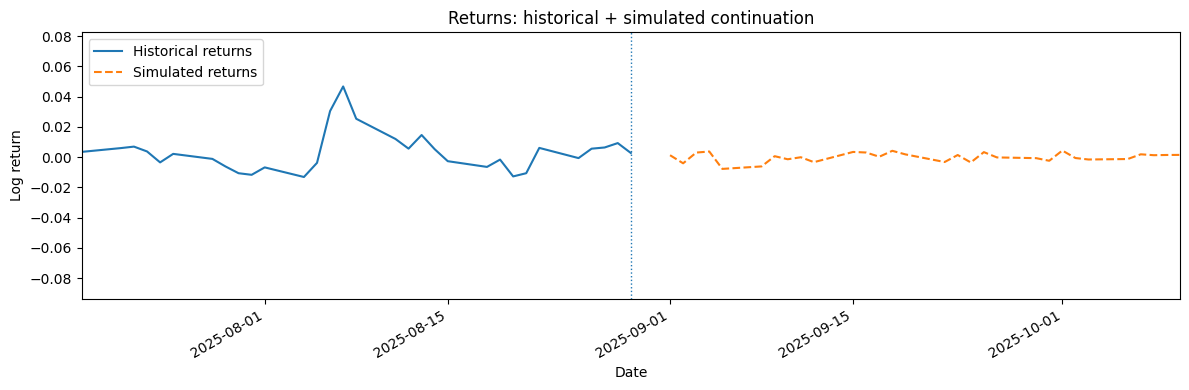

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
cont_df["returns_hist"].plot(ax=ax, label="Historical returns")
cont_df["returns_sim"].plot(ax=ax, linestyle="--", label="Simulated returns")

ax.set_xlim(last_date - BDay(30), last_date + BDay(30)) 

ax.axvline(last_date, linestyle=":", linewidth=1)
ax.set_title("Returns: historical + simulated continuation")
ax.set_xlabel("Date")
ax.set_ylabel("Log return")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()